# Model Training

## Imports

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
import numpy as np
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from IPython.display import clear_output
from tensorflow.keras.utils import to_categorical
from itertools import combinations
import gc

## Loading best result grid search

In [2]:
df = pd.read_csv("/kaggle/input/image-size-gridsearch-result/image_size_gridsearch_result.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df = df.sort_values("test_accuracy", ascending=False)
df.head()

,statistic,interpolation,width,height,epochs,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,test_loss,precision,recall
4,min,lanczos3,106,108,18,0.987500,0.9450,0.9725,0.116431,0.188167,0.099473,0.994764,0.950
13,25%,gaussian,314,383,16,0.966667,0.9275,0.9725,0.166130,0.385534,0.116675,0.989637,0.955
1,min,nearest,106,108,19,1.000000,0.9600,0.9675,0.001830,0.180720,0.156232,1.000000,0.935
9,25%,bicubic,314,383,15,0.989167,0.8050,0.9650,0.059487,1.681904,0.108875,0.969697,0.960
12,25%,lanczos5,314,383,16,0.981667,0.9550,0.9650,0.093961,0.378558,0.114040,0.979381,0.950


In [3]:
best_result = df.iloc[0]
width = best_result["width"]
height = best_result["height"]
statistic = best_result["statistic"]
interpolation = best_result["interpolation"]
painters = ["Mondriaan", "Picasso"]
base_dir = "/kaggle/input/schilderijen-datasets/smaller_oversampled_dataset"

## Helper functions

In [4]:
def build_model(width, height, data_augmentation=None):
    model = keras.Sequential()
    model.add(layers.InputLayer(shape=(width, height, 3)))

    if data_augmentation:
        model.add(data_augmentation)

    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(32, 3, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(64, 3, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(128, 3, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


model = build_model(width, height)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 106, 108, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 104, 106, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 104, 106, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 52, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 52, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 51, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 51, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 23, 23, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 23, 23, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,965,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,059,585 (15.49 MB)

 Trainable params: 4,059,137 (15.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [4]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

train, val, test = load_dataset(base_dir, painters, width, height, interpolation=interpolation)

Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [7]:
def print_metrics(model, test):
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test, verbose=0)

    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")

In [12]:
class DynamicMetricsPlotCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for metric in self.history.keys():
            if metric in logs:
                self.history[metric].append(logs[metric])

        clear_output(wait=True)
        plt.figure(figsize=(12, 4))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

## Model training

### Model listing 8.7

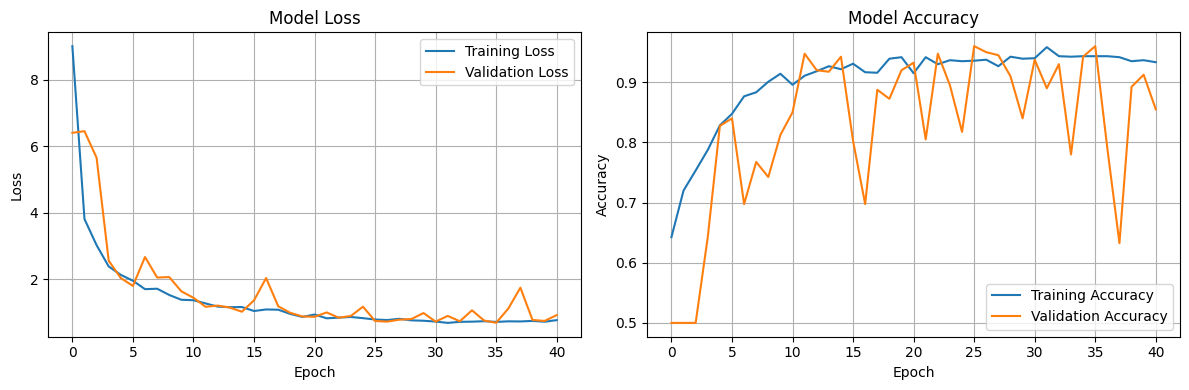

In [20]:
model = build_model(width, height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])

callbacks = [ModelCheckpoint(filepath="model.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [21]:
print_metrics(model, test)

Test Loss: 0.6910226941108704
Test Accuracy: 0.9549999833106995
Test Precision: 0.9739583134651184
Test Recall: 0.9350000023841858


### Model listing 8.7 met data augmentation 8.14

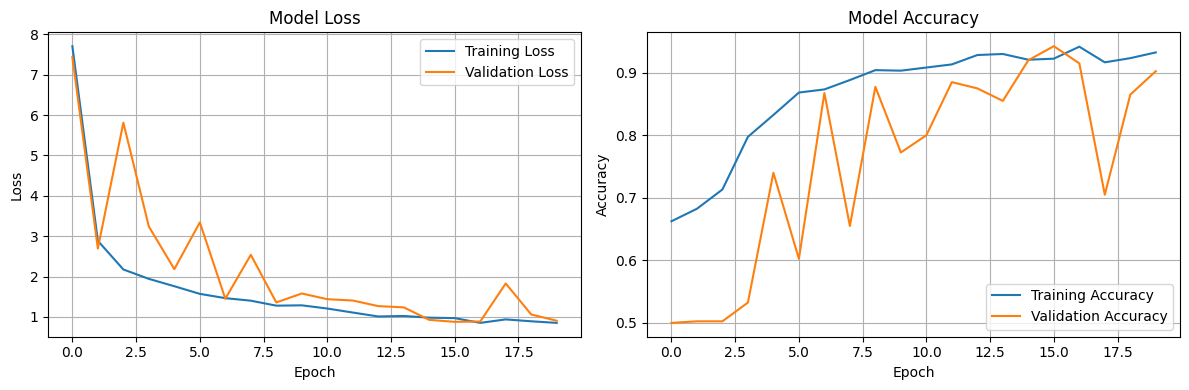

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
model = build_model(width, height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])

callbacks = [ModelCheckpoint(filepath="model.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, verbose=0)

In [23]:
print_metrics(model, test)

Test Loss: 0.8120517730712891
Test Accuracy: 0.9624999761581421
Test Precision: 0.9894179701805115
Test Recall: 0.9350000023841858


### Model listing 8.16

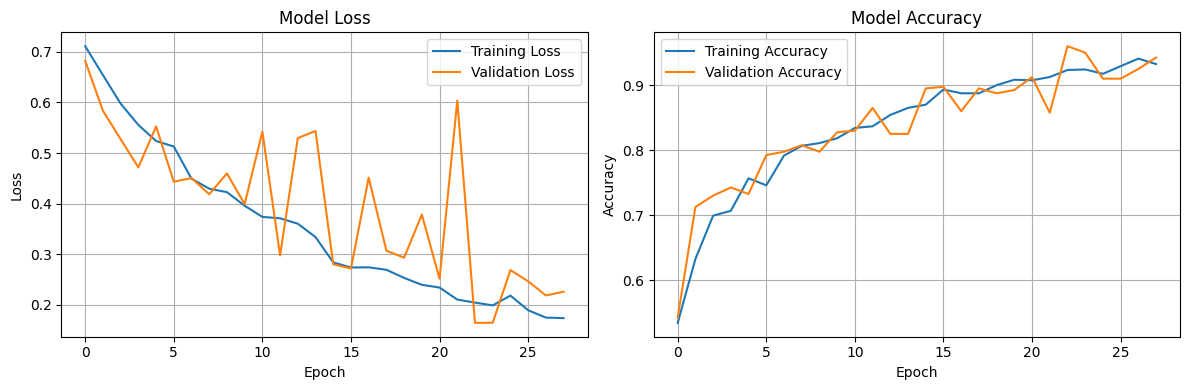

In [24]:
inputs = keras.Input(shape=(width, height, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])

callbacks = [ModelCheckpoint(filepath="model.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = model.fit(train, epochs=40, validation_data=val, verbose=0, callbacks=callbacks)

In [25]:
print_metrics(model, test)

Test Loss: 0.2356971949338913
Test Accuracy: 0.9375
Test Precision: 0.9729729890823364
Test Recall: 0.8999999761581421


### Feature extraction met VGG16

In [26]:
conv_base = keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(width, height, 3))
conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 106, 108, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 106, 108, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 106, 108, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 53, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 53, 54, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 53, 54, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 26, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 26, 27, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 26, 27, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 26, 27, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 13, 13, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 13, 13, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 13, 13, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
train_features, train_labels = get_features_and_labels(train)
val_features, val_labels = get_features_and_labels(val)
test_features, test_labels = get_features_and_labels(test)

In [28]:
train_features.shape

(1200, 3, 3, 512)

In [29]:
input_shape = (train_features.shape[1], train_features.shape[2], train_features.shape[3])
inputs = keras.Input(shape=input_shape)
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

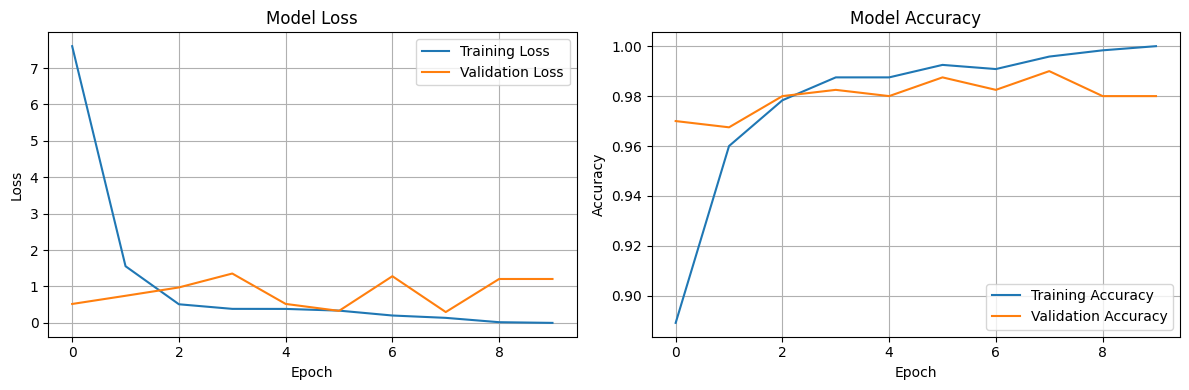

In [30]:
model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
callbacks = [ModelCheckpoint(filepath="model.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
history = model.fit(train_features, train_labels,epochs=10,validation_data=(val_features, val_labels),callbacks=callbacks, verbose=0)

### Uitbreiding met data augmentation

In [32]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet",include_top=False)
conv_base.trainable = False

In [33]:
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("This is the number of trainable weights "
"after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


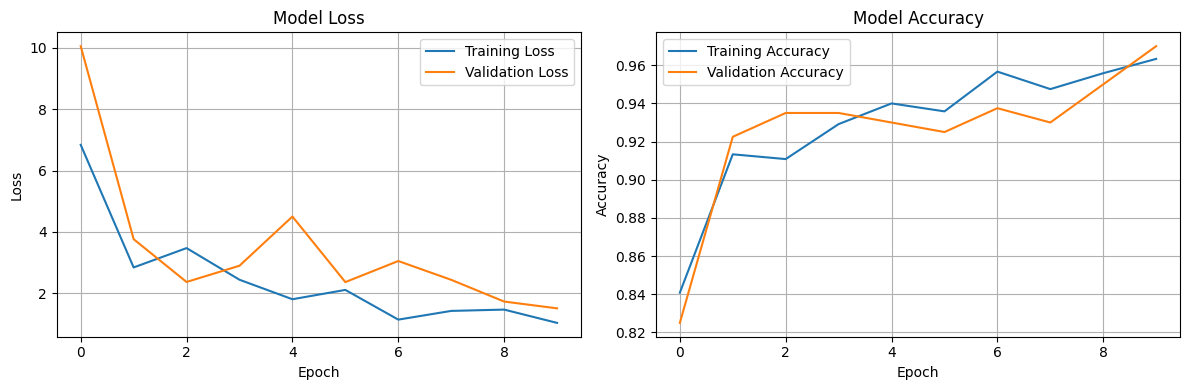

In [34]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ])
input_shape = (width, height, 3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction_with_data_augmentation.keras",save_best_only=True,monitor="val_loss")
             , DynamicMetricsPlotCallback()]
history = model.fit(train, epochs=10, validation_data=val, callbacks=callbacks, verbose=0)

In [35]:
print_metrics(model, test)

Test Loss: 1.4447417259216309
Test Accuracy: 0.9624999761581421
Test Precision: 0.9556650519371033
Test Recall: 0.9700000286102295


### Uitbreiding met eigen data augmentation

In [9]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet",include_top=False)
conv_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(0.3,0.3),
    ])

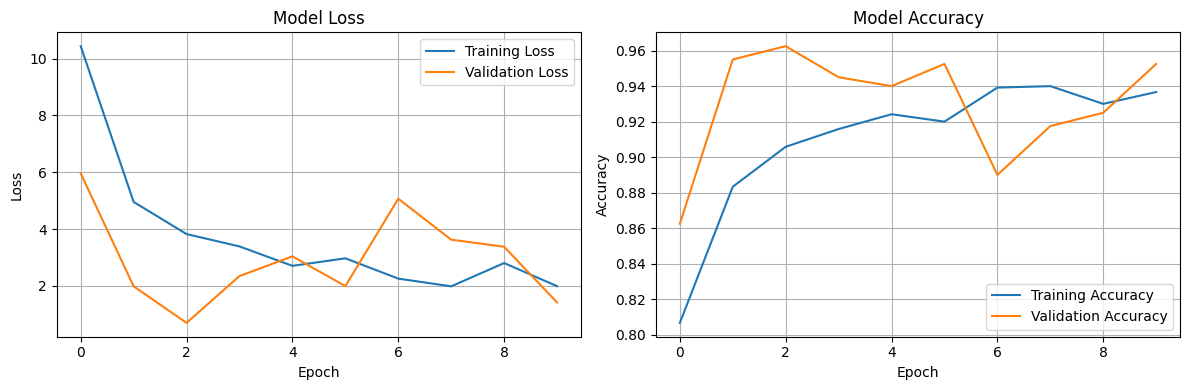

In [11]:
input_shape = (width, height, 3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction_with_data_augmentation.keras",save_best_only=True,monitor="val_loss")
             , DynamicMetricsPlotCallback()]
history = model.fit(train, epochs=10, validation_data=val, callbacks=callbacks, verbose=0)

In [12]:
print_metrics(model, test)

Test Loss: 1.004043459892273
Test Accuracy: 0.9599999785423279
Test Precision: 0.9842105507850647
Test Recall: 0.9350000023841858


### Finetuning van VGG16 conv base

In [13]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

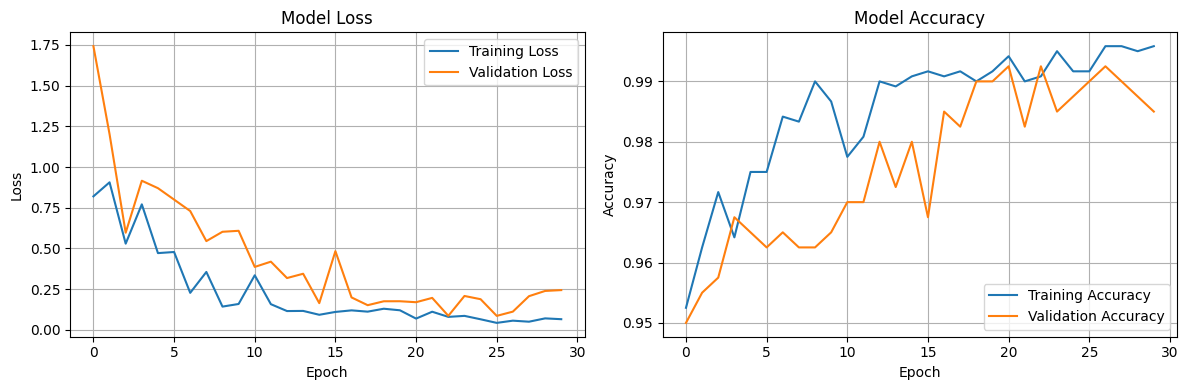

In [14]:
model.compile(loss="binary_crossentropy",optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="fine_tuning_vgg16.keras", save_best_only=True, monitor="val_loss")
             , DynamicMetricsPlotCallback()]
history = model.fit(train,epochs=30,validation_data=val,callbacks=callbacks, verbose=0)

In [15]:
print_metrics(model, test)

Test Loss: 0.1934400200843811
Test Accuracy: 0.9900000095367432
Test Precision: 0.9949495196342468
Test Recall: 0.9850000143051147


### Xception

In [18]:
conv_base = keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(width, height, 3))
#conv_base.summary()
conv_base.trainable = False

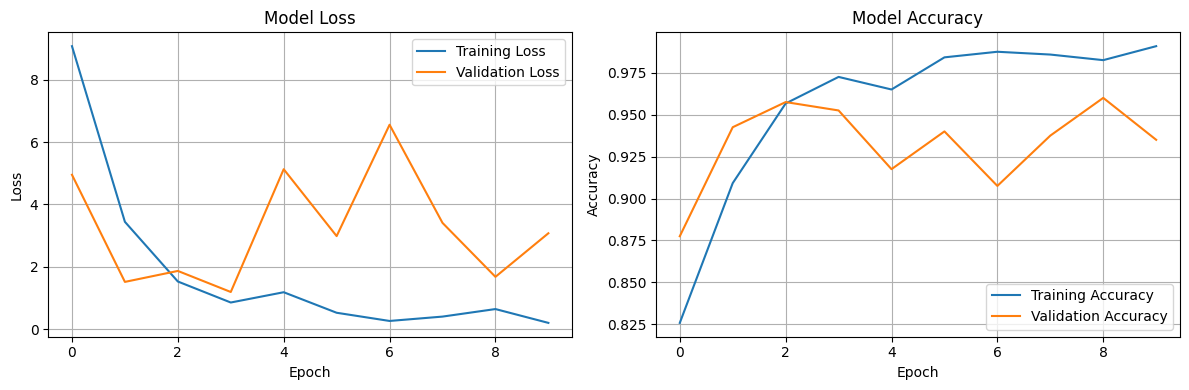

In [19]:
input_shape = (width, height, 3)
inputs = keras.Input(shape=input_shape)
x = keras.applications.xception.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction_with_data_augmentation.keras",save_best_only=True,monitor="val_loss")
            , DynamicMetricsPlotCallback()]
history = model.fit(train, epochs=10, validation_data=val, callbacks=callbacks, verbose=0)

In [20]:
print_metrics(model, test)

Test Loss: 1.7490020990371704
Test Accuracy: 0.9700000286102295
Test Precision: 1.0
Test Recall: 0.9399999976158142


### Xception met data augmentation

In [21]:
conv_base = keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(width, height, 3))
conv_base.trainable = False

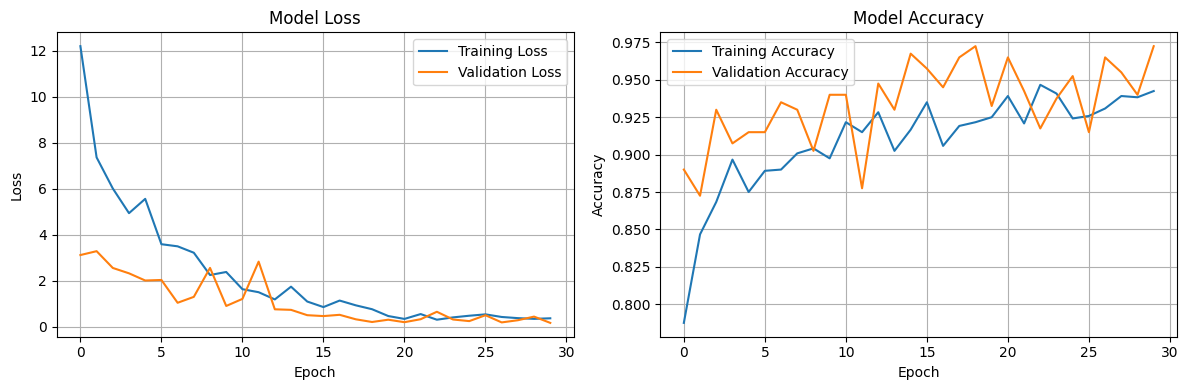

In [22]:
input_shape = (width, height, 3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = keras.applications.xception.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction_with_data_augmentation.keras",save_best_only=True,monitor="val_loss")
             , DynamicMetricsPlotCallback()]
history = model.fit(train, epochs=30, validation_data=val, callbacks=callbacks, verbose=0)

In [23]:
print_metrics(model, test)

Test Loss: 0.22215566039085388
Test Accuracy: 0.9674999713897705
Test Precision: 0.9605911374092102
Test Recall: 0.9750000238418579


### Finetuning van Xception

#### Laatste 4 lagen

In [24]:
conv_base = keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(width, height, 3))
conv_base.trainable = False

In [25]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

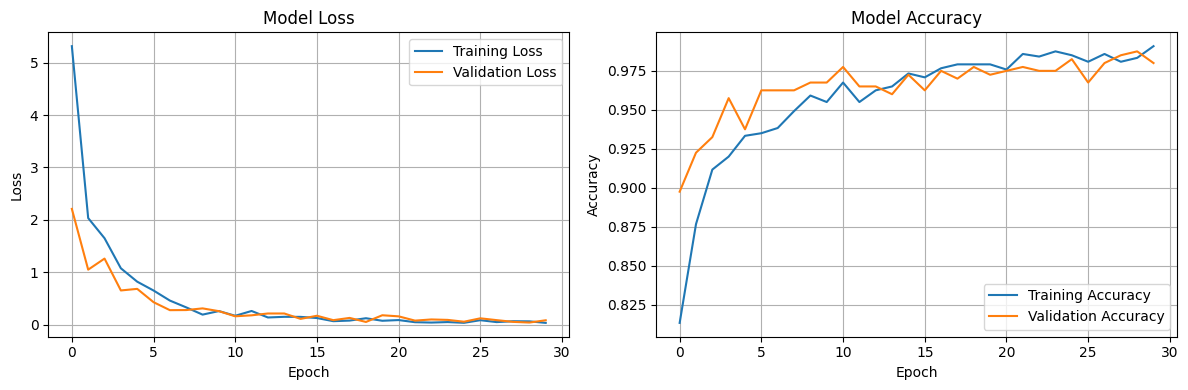

In [26]:
input_shape = (width, height, 3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = keras.applications.xception.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction_with_data_augmentation.keras",save_best_only=True,monitor="val_loss")
             , DynamicMetricsPlotCallback()]
history = model.fit(train, epochs=30, validation_data=val, callbacks=callbacks, verbose=0)

In [27]:
print_metrics(model, test)

Test Loss: 0.07181677967309952
Test Accuracy: 0.9900000095367432
Test Precision: 1.0
Test Recall: 0.9800000190734863


#### Laatste 8 lagen

In [31]:
conv_base = keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(width, height, 3))
conv_base.trainable = True
for layer in conv_base.layers[:-8]:
    layer.trainable = False

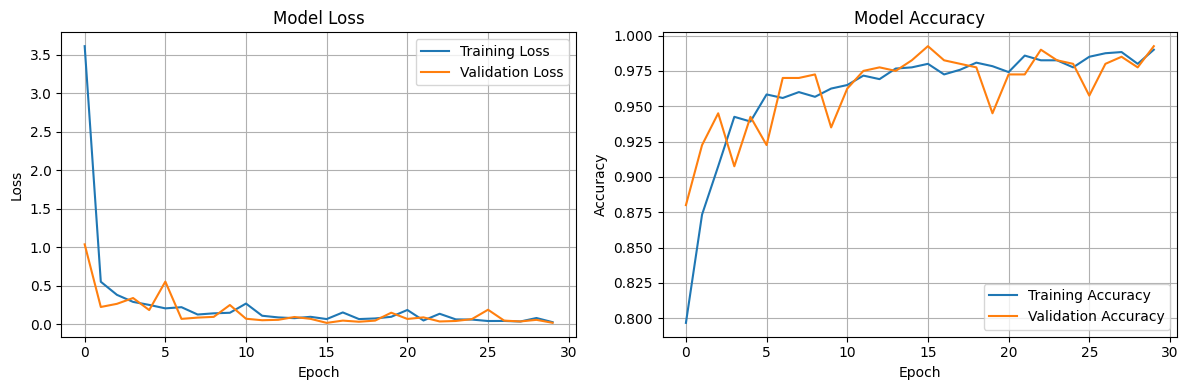

In [33]:
input_shape = (width, height, 3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = keras.applications.xception.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction_with_data_augmentation.keras",save_best_only=True,monitor="val_loss")
             , DynamicMetricsPlotCallback()]
history = model.fit(train, epochs=30, validation_data=val, callbacks=callbacks, verbose=0)

In [34]:
print_metrics(model, test)

Test Loss: 0.018274718895554543
Test Accuracy: 0.9950000047683716
Test Precision: 0.9950000047683716
Test Recall: 0.9950000047683716


#### Laatste 12 lagen

In [36]:
conv_base = keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(width, height, 3))
conv_base.trainable = True
for layer in conv_base.layers[:-12]:
    layer.trainable = False

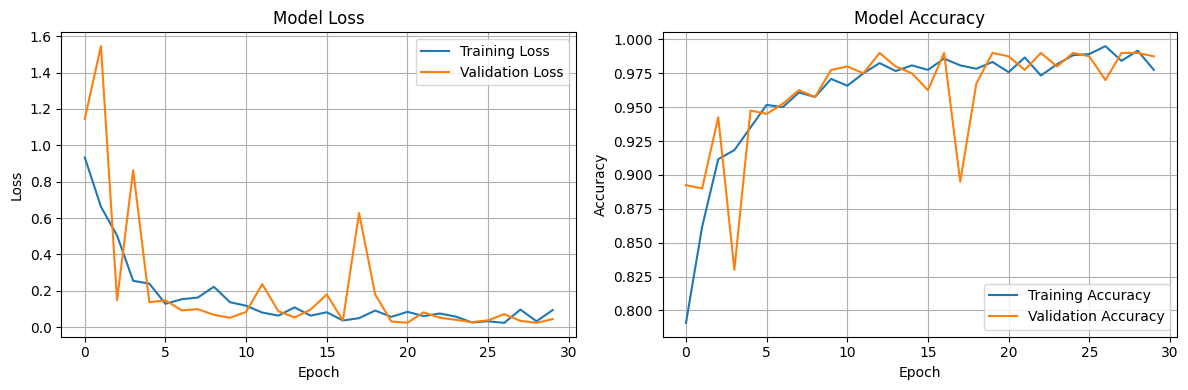

In [37]:
input_shape = (width, height, 3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = keras.applications.xception.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction_with_data_augmentation.keras",save_best_only=True,monitor="val_loss")
             , DynamicMetricsPlotCallback()]
history = model.fit(train, epochs=30, validation_data=val, callbacks=callbacks, verbose=0)

In [38]:
print_metrics(model, test)

Test Loss: 0.03160597383975983
Test Accuracy: 0.987500011920929
Test Precision: 1.0
Test Recall: 0.9750000238418579


## Alle combinaties met 2 schilders testen met beste model

In [15]:
def get_metrics(model, test, history, painters):
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test, verbose=0)

    result = {
        "painters": painters,
        "train_accuracy": history.history['accuracy'][-1],
        "val_accuracy": history.history['val_accuracy'][-1],
        "test_accuracy": test_accuracy,
        "train_loss": history.history['loss'][-1],
        "val_loss": history.history['val_loss'][-1],
        "precision": test_precision,
        "recall": test_recall,
    }
    return result

In [17]:
input_shape = (width, height, 3)
painters = ["Mondriaan", "Rembrandt", "Rubens", "Picasso"]
combinations_of_two = list(combinations(painters,2))
callbacks = [keras.callbacks.ModelCheckpoint(filepath="grid_search.keras", save_best_only=True, monitor="val_loss")
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
results = []

for combination in combinations_of_two:
    conv_base = keras.applications.xception.Xception(weights="imagenet",include_top=False)
    conv_base.trainable = True
    for layer in conv_base.layers[:-8]:
        layer.trainable = False

    train, val, test = load_dataset(base_dir, combination, width, height, interpolation=interpolation)

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = keras.applications.xception.preprocess_input(x)
    x = conv_base(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
    history = model.fit(train,epochs=50,validation_data=val,callbacks=callbacks, verbose=0)

    result = get_metrics(model, test, history, combination)
    print(result)
    results.append(result)
    del train, val, test, model
    gc.collect()
df = pd.DataFrame(results)

Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
{'painters': ('Mondriaan', 'Rembrandt'), 'train_accuracy': 0.9866666793823242, 'val_accuracy': 0.9925000071525574, 'test_accuracy': 0.9975000023841858, 'train_loss': 0.05430318042635918, 'val_loss': 0.026659056544303894, 'precision': 0.9950248599052429, 'recall': 1.0}
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
{'painters': ('Mondriaan', 'Rubens'), 'train_accuracy': 0.9641666412353516, 'val_accuracy': 0.9850000143051147, 'test_accuracy': 0.949999988079071, 'train_loss': 0.21272069215774536, 'val_loss': 0.1144178956747055, 'precision': 0.9285714030265808, 'recall': 0.9750000238418579}
Found 1200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
{'painters': ('Mondriaan', 'Picasso'), 'train_accuracy': 0.9483333230018616, 'val_accuracy

In [18]:
df.sort_values("test_accuracy", ascending=False)

,painters,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall
0,"(Mondriaan, Rembrandt)",0.986667,0.9925,0.9975,0.054303,0.026659,0.995025,1.000
4,"(Rembrandt, Picasso)",0.959167,0.9750,0.9625,0.220155,0.271348,0.938389,0.990
1,"(Mondriaan, Rubens)",0.964167,0.9850,0.9500,0.212721,0.114418,0.928571,0.975
5,"(Rubens, Picasso)",0.925000,0.9700,0.9125,0.273257,0.253985,0.876712,0.960
2,"(Mondriaan, Picasso)",0.948333,0.9225,0.9025,0.260568,0.694797,0.935135,0.865
3,"(Rembrandt, Rubens)",0.909167,0.9150,0.8175,0.337287,0.390172,0.875740,0.740


In [19]:
df["test_accuracy"].mean()

0.9237499932448069

## Alle combinaties met 3 schilders testen met beste model

In [34]:
def get_metrics(model, test, history, painters):
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test, verbose=0)

    result = {
        "painters": painters,
        "train_accuracy": history.history['accuracy'][-1],
        "val_accuracy": history.history['val_accuracy'][-1],
        "test_accuracy": test_accuracy,
        "train_loss": history.history['loss'][-1],
        "val_loss": history.history['val_loss'][-1],
        "precision": test_precision,
        "recall": test_recall,
    }
    return result

In [8]:
def one_hot_encode_labels(dataset, num_classes):
    dataset = dataset.map(lambda x, y: (x, to_categorical(y, num_classes=num_classes)))
    return dataset

In [37]:
input_shape = (width, height, 3)
painters = ["Mondriaan", "Rembrandt", "Rubens", "Picasso"]
combinations_of_three = list(combinations(painters,3))
callbacks = [keras.callbacks.ModelCheckpoint(filepath="grid_search.keras", save_best_only=True, monitor="val_loss")
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
results = []

for combination in combinations_of_three:
    conv_base = keras.applications.xception.Xception(weights="imagenet",include_top=False)
    conv_base.trainable = True
    for layer in conv_base.layers[:-8]:
        layer.trainable = False

    train, val, test = load_dataset(base_dir, combination, width, height, interpolation=interpolation)
    train = one_hot_encode_labels(train, 3)
    val = one_hot_encode_labels(val, 3)
    test = one_hot_encode_labels(test, 3)

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = keras.applications.xception.preprocess_input(x)
    x = conv_base(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
    history = model.fit(train,epochs=50,validation_data=val,callbacks=callbacks, verbose=0)

    result = get_metrics(model, test, history, combination)
    print(result)
    results.append(result)
    del train, val, test, model
    gc.collect()
df = pd.DataFrame(results)

Found 1800 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
{'painters': ('Mondriaan', 'Rembrandt', 'Rubens'), 'train_accuracy': 0.9588888883590698, 'val_accuracy': 0.9150000214576721, 'test_accuracy': 0.9766666889190674, 'train_loss': 0.15665249526500702, 'val_loss': 0.3276994824409485, 'precision': 0.9766666889190674, 'recall': 0.9766666889190674}
Found 1800 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
{'painters': ('Mondriaan', 'Rembrandt', 'Picasso'), 'train_accuracy': 0.9083333611488342, 'val_accuracy': 0.8149999976158142, 'test_accuracy': 0.8133333325386047, 'train_loss': 0.36830636858940125, 'val_loss': 0.9199963212013245, 'precision': 0.8146911263465881, 'recall': 0.8133333325386047}
Found 1800 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
{'painters': ('Mondriaan', 'Rubens', 'Picasso'), 'tr

In [38]:
df.sort_values("test_accuracy", ascending=False)

,painters,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall
0,"(Mondriaan, Rembrandt, Rubens)",0.958889,0.915000,0.976667,0.156652,0.327699,0.976667,0.976667
2,"(Mondriaan, Rubens, Picasso)",0.901111,0.893333,0.876667,0.549456,0.621714,0.880672,0.873333
1,"(Mondriaan, Rembrandt, Picasso)",0.908333,0.815000,0.813333,0.368306,0.919996,0.814691,0.813333
3,"(Rembrandt, Rubens, Picasso)",0.858889,0.813333,0.691667,0.583843,1.314659,0.691919,0.685000


In [39]:
df["test_accuracy"].mean()

0.8395833373069763

## Classificatie van 4 schilders

In [16]:
def get_metrics(model, test, history):
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test, verbose=0)

    result = {
        "train_accuracy": history.history['accuracy'][-1],
        "val_accuracy": history.history['val_accuracy'][-1],
        "test_accuracy": test_accuracy,
        "train_loss": history.history['loss'][-1],
        "val_loss": history.history['val_loss'][-1],
        "precision": test_precision,
        "recall": test_recall,
    }
    return result

In [45]:
input_shape = (width, height, 3)
painters = ["Mondriaan", "Rembrandt", "Rubens", "Picasso"]
combinations_of_three = list(combinations(painters,3))
callbacks = [keras.callbacks.ModelCheckpoint(filepath="grid_search.keras", save_best_only=True, monitor="val_loss")
            ,EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

conv_base = keras.applications.xception.Xception(weights="imagenet",include_top=False)
conv_base.trainable = True
for layer in conv_base.layers[:-8]:
    layer.trainable = False

train, val, test = load_dataset(base_dir, combination, width, height, interpolation=interpolation)
train = one_hot_encode_labels(train, 4)
val = one_hot_encode_labels(val, 4)
test = one_hot_encode_labels(test, 4)

inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = keras.applications.xception.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train,epochs=50,validation_data=val,callbacks=callbacks, verbose=0)

result = get_metrics(model, test, history)
print(result)

Found 1800 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
{'train_accuracy': 0.9183333516120911, 'val_accuracy': 0.9200000166893005, 'test_accuracy': 0.9483333230018616, 'train_loss': 0.22193945944309235, 'val_loss': 0.2938520014286041, 'precision': 0.9497487545013428, 'recall': 0.9449999928474426}


## Final model

In [18]:
def get_metrics(model, test, history, painters):
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test, verbose=0)

    result = {
        "painters": painters,
        "train_accuracy": history.history['accuracy'][-1],
        "test_accuracy": test_accuracy,
        "train_loss": history.history['loss'][-1],
        "precision": test_precision,
        "recall": test_recall,
    }
    return result

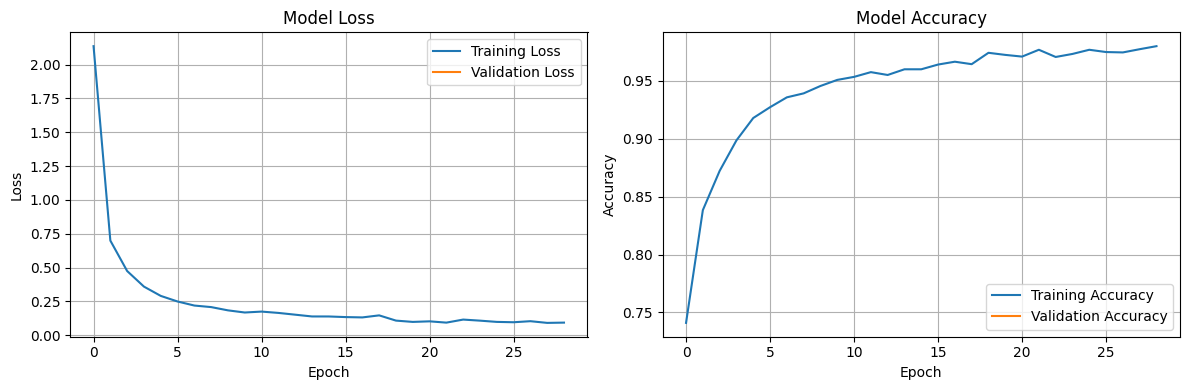

In [19]:
base_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
painters = ["Mondriaan", "Rembrandt", "Rubens", "Picasso"]

train, val, test = load_dataset(base_dir, painters, width, height, interpolation=interpolation)
combinet_dataset = train.concatenate(val).concatenate(test)
combinet_dataset = one_hot_encode_labels(combinet_dataset, 4)

input_shape = (width, height, 3)
callbacks = [keras.callbacks.ModelCheckpoint(filepath="final_model.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]

conv_base = keras.applications.xception.Xception(weights="imagenet",include_top=False)
conv_base.trainable = True
for layer in conv_base.layers[:-8]:
    layer.trainable = False


inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = keras.applications.xception.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(combinet_dataset,epochs=29,callbacks=callbacks, verbose=0)
print(history.history['accuracy'][-1])
